In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("data/missense3d-benchmarking_PDBeKB_foldx.csv")

In [3]:
df = pd.concat([df, pd.get_dummies(df["#RES_sec_struct"],prefix="#SEC_STRUCT")], axis=1)

In [4]:
df["#DDG_total_log"] = df["#DDG_total"].apply(np.log) 

<AxesSubplot:xlabel='#DDG_total'>

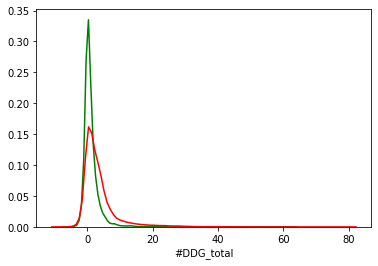

In [5]:
sns.distplot(df.loc[df["#FINAL_ANNOTATION"] == "BENIGN"]["#DDG_total"], color="g", hist=False)
sns.distplot(df.loc[df["#FINAL_ANNOTATION"] == "PATHOGENIC"]["#DDG_total"], color="r", hist=False) 

In [6]:
df.columns

Index(['Unnamed: 0', '#UNIPROT_ID', '#UNIPROT_POS', '#RESWT', '#RESMUT',
       '#PDBPOS', '#PDB', '#CHAIN', '#STRUCT_DET_METHOD', '#HUMSAVAR_ANNO',
       '#CLINVAR_ANNO', '#MAF(GNOMAD)', '#FINAL_ANNOTATION', '#BENCHMARK',
       '#DDG_total', '#DDG_backHbond', '#DDG_sideHbond', '#DDG_energy_VdW',
       '#DDG_electro', '#DDG_energy_SolvP', '#DDG_energy_SolvH',
       '#DDG_energy_vdwclash', '#DDG_entrop_sc', '#DDG_entrop_mc',
       '#DDG_sloop_entropy', '#DDG_mloop_entropy', '#DDG_cis_bond',
       '#DDG_energy_torsion', '#DDG_backbone_vdwclash', '#DDG_energy_dipole',
       '#DDG_water', '#DDG_disulfide', '#DDG_energy_kon', '#DDG_partcov',
       '#DDG_energyIonisation', '#DDG_entr_complex', '#RES_omega', '#RES_phi',
       '#RES_psi', '#RES_sec_struct', '#INTERFACE_ddG', '#INTERFACE_wt_res',
       '#INTERFACE_mt_res', '#NETWORKS_vdw', '#NETWORKS_vdw_diff',
       '#NETWORKS_hbond', '#NETWORKS_hbond_diff', '#BFACTOR_relative',
       '#SEC_STRUCT_*', '#SEC_STRUCT_B', '#SEC_STRUCT_

In [7]:
feature_columns = ["#DDG_total","#DDG_backHbond","#DDG_sideHbond","#DDG_energy_VdW","#DDG_electro","#DDG_energy_SolvP",
               "#DDG_energy_SolvH","#DDG_energy_vdwclash","#DDG_entrop_sc","#DDG_entrop_mc","#DDG_sloop_entropy",
               "#DDG_mloop_entropy","#DDG_cis_bond","#DDG_energy_torsion","#DDG_backbone_vdwclash","#DDG_energy_dipole",
               "#DDG_water","#DDG_disulfide","#DDG_energy_kon","#DDG_partcov","#DDG_energyIonisation","#DDG_entr_complex",
               "#RES_omega","#RES_phi","#RES_psi","#INTERFACE_ddG","#INTERFACE_wt_res","#INTERFACE_mt_res",
               "#NETWORKS_vdw","#NETWORKS_vdw_diff","#NETWORKS_hbond","#NETWORKS_hbond_diff","#BFACTOR_relative",
               '#SEC_STRUCT_*', '#SEC_STRUCT_B', '#SEC_STRUCT_E', '#SEC_STRUCT_T',
               '#SEC_STRUCT_Th', '#SEC_STRUCT_a', '#SEC_STRUCT_b', '#SEC_STRUCT_c',
               '#SEC_STRUCT_m', '#SEC_STRUCT_n']

#feature_columns =["#DDG_total","#INTERFACE_ddG","#INTERFACE_wt_res","#INTERFACE_mt_res",
#               "#NETWORKS_vdw","#NETWORKS_vdw_diff","#NETWORKS_hbond","#NETWORKS_hbond_diff","#BFACTOR_relative"]

features = df.loc[df['#STRUCT_DET_METHOD']=="X-RAY"][feature_columns + ["#FINAL_ANNOTATION"]]

features.dropna(inplace=True)

labels = features[["#FINAL_ANNOTATION"]]
features = features[feature_columns]

In [8]:
msk = np.random.rand(len(features)) < 0.9

features_train = features[msk]
labels_train = labels[msk]
features_test = features[~msk]
labels_test = labels[~msk]

print(features_train.shape)
print(features_test.shape)

(23254, 43)
(2547, 43)


In [9]:
clf = RandomForestClassifier(n_estimators=500, n_jobs=4, max_features=None)
clf.fit(features_train, labels_train)
#clf.fit(features, labels)

<ipython-input-9-a4338034a092>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(features_train, labels_train)


RandomForestClassifier(max_features=None, n_estimators=500, n_jobs=4)

In [10]:
clf.score(features_test, labels_test)

0.7204554377699254

In [11]:
clf.classes_

array(['BENIGN', 'CONFLICT', 'PATHOGENIC'], dtype=object)

In [12]:
true_benign = []
false_benign = []
true_pathogenic = []
false_pathogenic = []


for i, frow in features_test.iterrows():
    proba = clf.predict_proba( [frow.tolist()] )[0]
    
    if labels_test.loc[i]["#FINAL_ANNOTATION"]  == 'BENIGN':
        if proba[0] > 0.5:
            true_benign.append( proba[0] )
        else:
            false_pathogenic.append( proba[2] )
            
    elif labels_test.loc[i]["#FINAL_ANNOTATION"]  == 'PATHOGENIC':
        if proba[2] > 0.5:
            true_pathogenic.append( proba[2] )
        else:
            false_benign.append( proba[0] )

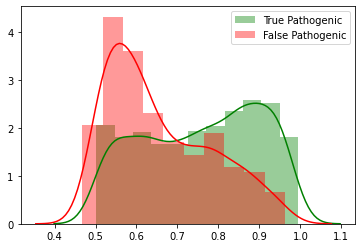

In [16]:
sns.distplot(true_pathogenic, color="g", label="True Pathogenic")
sns.distplot(false_pathogenic, color="r", label="False Pathogenic")
plt.legend()

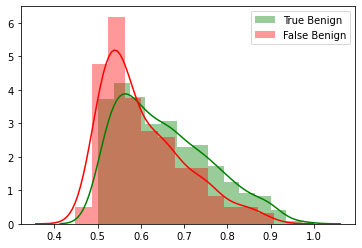

In [17]:
sns.distplot(true_benign, color="g", label="True Benign")
sns.distplot(false_benign, color="r", label="False Benign")
plt.legend()

In [18]:
print(len(true_benign))
print(len(false_benign))
print(len(true_pathogenic))
print(len(false_pathogenic))


623
312
1195
394


In [19]:
df.columns

Index(['Unnamed: 0', '#UNIPROT_ID', '#UNIPROT_POS', '#RESWT', '#RESMUT',
       '#PDBPOS', '#PDB', '#CHAIN', '#STRUCT_DET_METHOD', '#HUMSAVAR_ANNO',
       '#CLINVAR_ANNO', '#MAF(GNOMAD)', '#FINAL_ANNOTATION', '#BENCHMARK',
       '#DDG_total', '#DDG_backHbond', '#DDG_sideHbond', '#DDG_energy_VdW',
       '#DDG_electro', '#DDG_energy_SolvP', '#DDG_energy_SolvH',
       '#DDG_energy_vdwclash', '#DDG_entrop_sc', '#DDG_entrop_mc',
       '#DDG_sloop_entropy', '#DDG_mloop_entropy', '#DDG_cis_bond',
       '#DDG_energy_torsion', '#DDG_backbone_vdwclash', '#DDG_energy_dipole',
       '#DDG_water', '#DDG_disulfide', '#DDG_energy_kon', '#DDG_partcov',
       '#DDG_energyIonisation', '#DDG_entr_complex', '#RES_omega', '#RES_phi',
       '#RES_psi', '#RES_sec_struct', '#INTERFACE_ddG', '#INTERFACE_wt_res',
       '#INTERFACE_mt_res', '#NETWORKS_vdw', '#NETWORKS_vdw_diff',
       '#NETWORKS_hbond', '#NETWORKS_hbond_diff', '#BFACTOR_relative',
       '#SEC_STRUCT_*', '#SEC_STRUCT_B', '#SEC_STRUCT_